# Implementing Anomaly Detection Models

In this exercise sheet, several kernel-based anomaly detection models will be implemented and their behavior compared on a simple two-dimensional dataset. The following code builds a dataset generated as a mixture of several Gaussian blobs.

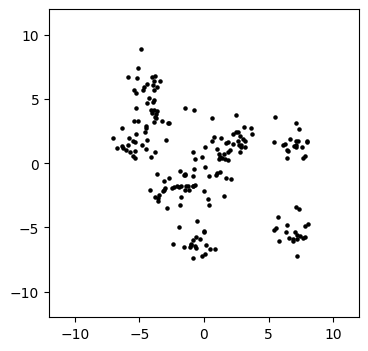

In [5]:
import sklearn.datasets
import sklearn.metrics
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import utils

X = sklearn.datasets.make_blobs(n_samples=200,centers=10,random_state=2)[0]
X = X - X.mean(axis=0)
X = X / X.std() * 4.0

utils.plot(X,None)

### Kernel Density Estimation (10 P)

The first anomaly detection model is based on kernel density estimation (KDE). KDE builds the function

$$
f(x) = \frac1N \sum_{n=1}^N k(x,x_n)
$$

where the output forms here an unnormalized probability density function. Note that if only interested in producing an ordering of points from least to most outlier, we don't need to normalize $f(x)$. However, because $f(x)$ is more a measure of inlierness than outlierness, we can define the outlier score $o(x)$ as a decreasing function of $f(x)$ and also make sure the function goes to infinity for very remote data points. This can be achieved with the scoring function:

$$
o(x) = - \log(f(x))
$$

We now would like to implement KDE using an interface similar to how ML algorithms are provided in scikit-learn, in particular, by defining a class that implements a `fit` function for training based on some training data `X` and a `predict` function for computing the prediction for a new set of points `X`. The KDE class is initialized with a kernel function (typically a Gaussian kernel). Its functions for training and predicting are incomplete.

**Task:**

* **Implement the functions `fit(self,X)` and `predict(self,X)` of the class `KDE`.**

In [7]:
class KDE:

    def __init__(self, kernel):
        self.kernel = kernel

    def fit(self, X):
        # TODO: replace by your code
        self.prob = lambda X_predict: self.kernel(X, X_predict).mean(0)
        return self

    def predict(self, X):
        # TODO: replace by your code
        o = -np.log10(self.prob(X))
        return o


The KDE model can now be tested on our two-dimensional data. The code below passes to the KDE model a Gaussian kernel of scale $\gamma=0.25$ (i.e. the bandwidth is slightly larger than for the default Gaussian kernel), train the model on the Gaussian blobs data, and apply the model to a grid dataset for the purpose of building a contour plot.

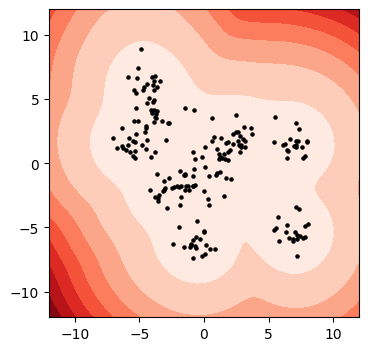

In [8]:
kernel = lambda x,y: sklearn.metrics.pairwise.rbf_kernel(x,y,gamma=0.25)
utils.plot(X,KDE(kernel).fit(X).predict(utils.Xgrid))

We observe that model behaves as expected, i.e. the regions outside the data are highlighted in red, which corresponds to high outlier scores.

### Uncentered Kernel PCA Anomaly Detection (15 P)

Another model for anomaly detection is based on Kernel PCA. Here, we consider an uncentered version of Kernel PCA where we do not subtract the mean of the data in feature space. Kernel PCA relies on the Gram matrix:

$$
[K]_{nn'} = k(x_n,x_{n'})
$$

and its decomposition into eigenvectors and eigenvalues:

$$
K = V \Lambda V^\top.
$$

The matrix $\Lambda$ is diagonal and contains all eigenvalues $\lambda_1,\dots,\lambda_N$ sorted in descending order. The columns of the matrix $V$ are the corresponding eigenvectors. For the training data, projection of the $n$-th data point on the $i$-th principal component is readily given by

$$
\text{proj}_i(x_n) = V_{n,i} \cdot \lambda_{i}^{0.5}
$$

For new data points $x \in \mathbb{R}^d$, the projection is computed via:

$$
\text{proj}_i(x) = k(x,X) \cdot V_{:,i} \cdot \lambda_{i}^{-0.5}
$$

The latter produces equivalent results for points $(x_n)_n$ in the dataset but it generalizes the projection to any other point $x \in \mathbb{R}^d$. Once the data has been projected on the principal components, the outlier score can be computed as:

\begin{align*}
o(x) &= k(x,x) - \sum_{i=1}^{a} \big( \text{proj}_i(x) \big)^2
\end{align*}

An incomplete version of uncentered kernel PCA anomaly detection is given below. Like for KDE, it receives a kernel as input, but one also needs to needs to specify the number of dimensions used in the Kernel PCA model.

**Task:**

* **Implement the functions `fit(self,X)` and `predict(self,X)` of the class `UKPCA`.**

In [10]:
class UKPCA:

    def __init__(self, kernel, dims):
        self.kernel = kernel
        self.dims = dims

    def fit(self, X):
        self.X = X
        gram_matrix = self.kernel(X, X)
        eig_val, eig_vec = np.linalg.eigh(gram_matrix)

        # Verifying equation 2 of the task (sanity check):
        lambda_ = np.identity(len(eig_val)) * eig_val
        assert np.allclose(gram_matrix, eig_vec @ lambda_ @ eig_vec.T)

        self.eig_val = eig_val[-self.dims:]
        self.eig_vec = eig_vec[:, -self.dims:]
        return self

    def predict(self, X):
        gram_matrix = self.kernel(X, self.X)
        proj_predict = gram_matrix @ self.eig_vec / np.sqrt(self.eig_val)

        o = self.kernel(X, X).diagonal() - (proj_predict ** 2).sum(1)
        return o


The kernel PCA approach can now be tested. We first consider a kPCA model with a linear kernel and where we retain only the first principal component.

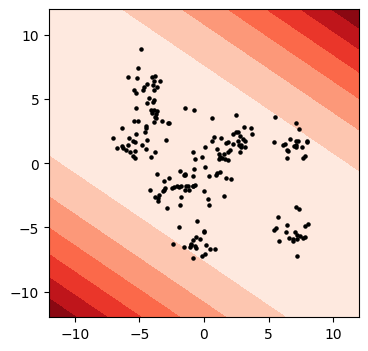

In [11]:
kernel = sklearn.metrics.pairwise.linear_kernel
utils.plot(X,UKPCA(kernel,1).fit(X).predict(utils.Xgrid))

The outlier score grows along the second principal component (the one with least variance). We now consider instead a Gaussian  kernel (of slightly larger bandwidth than the one used for KDE) and build a the outlier function from a KPCA model containing 25 principal components.

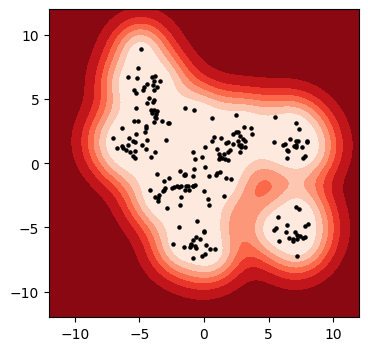

In [12]:
kernel = lambda x,y: sklearn.metrics.pairwise.rbf_kernel(x,y,gamma=0.1)
utils.plot(X,UKPCA(kernel,25).fit(X).predict(utils.Xgrid))

Here, we observe that the outlier model much more closely follows the shape of the data distribution. However, we also observe that it saturates away from the data, which does not reflect the true degree of outlierness.

### One-Class SVM (25 P)

The one-class SVM is another approach to anomaly detection that aims to build some envelope that contains the inliner data and that separates it from outlier data. In its dual form, it consists of solving the constrained optimization problem:
$$
\newcommand{\balpha}{\boldsymbol{\alpha}}
\min_{\balpha}~~ \frac12 \balpha^\top K \balpha
$$
subject to
$$
\boldsymbol{1}^\top\balpha = 1
\quad \text{and} \quad \begin{pmatrix}-I\\I\end{pmatrix} \balpha \preceq \begin{pmatrix}\boldsymbol{0}\\\boldsymbol{1}/N\nu\end{pmatrix}
$$
To solve this optimization problem, we can use the quadratic solver provided as part of `cvxopt` and the interface of which is shown below:

![](qp.png)

Once the solution has been found, the output score can be computed as $f(x) = \sum_i \alpha_i k(x,x_i)$. Similarly to the outlier scores we have computed for KDE, we can build a transformation

$$
o(x) = -\log \frac{\sum_i \alpha_i k(x,x_i)}{\sum_i \alpha_i k(x_\mathrm{SSV},x_i)}
$$

where $x_\mathrm{SSV}$ is any 'strict' support vector (they can be identified as implementing the box constraints above with strict inequalities). With this transformation the equation $o(x)=0$ also gives the OC-SVM decision boundary.

**Task:**

* **Implement the functions `fit(self,X)` and `predict(self,X)` of the class `OCSVM`.**

In [13]:
import cvxopt
import cvxopt.solvers

class OCSVM:

    def __init__(self, kernel, nu):
        self.kernel = kernel
        self.nu = nu

    def fit(self, X):
        N = len(X)
        I = np.identity(N)
        zeros = np.zeros(N)
        ones = np.ones(N)

        P = cvxopt.matrix(self.kernel(X, X))
        q = cvxopt.matrix(zeros)
        G = cvxopt.matrix(np.concatenate([-I, I]))
        h = cvxopt.matrix(np.concatenate([zeros, ones / (N * self.nu)]))
        A = cvxopt.matrix(ones).T
        b = cvxopt.matrix(np.array([1.0]))

        self.X = X
        self.alpha = cvxopt.solvers.qp(P, q, G, h, A, b)['x']
        return self

    def predict(self, X):
        N = len(X)
        # support vector data point
        support_vector = np.argmin(np.abs(np.array(self.alpha) - 1 / (2 * N * self.nu)))

        f = self.kernel(X, self.X) @ self.alpha
        fsv = self.kernel(self.X[support_vector:support_vector + 1], self.X) @ self.alpha

        o = -np.log(f / fsv)
        return o


The OC-SVM can now be tested on the 2d dataset. Here, we first consider the case where $\nu = 0.0001$, which corresponds to implementing a hard envelope (with no points outside of it).

     pcost       dcost       gap    pres   dres
 0:  5.9756e-02 -1.0097e+04  1e+04  2e-13  2e-13
 1:  5.9751e-02 -1.0853e+02  1e+02  2e-15  3e-13
 2:  5.9521e-02 -4.9829e+00  5e+00  4e-16  1e-14
 3:  7.0927e-02 -4.2701e+00  4e+00  8e-16  1e-14
 4:  7.4758e-02 -3.5860e+00  4e+00  2e-16  9e-15
 5:  6.8449e-02 -1.8468e-01  3e-01  4e-16  1e-15
 6:  6.2819e-02 -1.0865e-01  2e-01  2e-16  4e-16
 7:  5.9641e-02  1.9806e-02  4e-02  2e-16  5e-16
 8:  5.5603e-02  3.9579e-02  2e-02  1e-16  3e-16
 9:  5.4303e-02  4.7196e-02  7e-03  4e-16  3e-16
10:  5.3536e-02  5.1293e-02  2e-03  2e-16  2e-16
11:  5.3182e-02  5.2474e-02  7e-04  2e-16  2e-16
12:  5.3067e-02  5.2747e-02  3e-04  5e-16  3e-16
13:  5.2983e-02  5.2925e-02  6e-05  8e-16  3e-16
14:  5.2968e-02  5.2951e-02  2e-05  6e-16  2e-16
15:  5.2963e-02  5.2960e-02  3e-06  5e-16  2e-16
16:  5.2962e-02  5.2961e-02  3e-07  6e-16  3e-16
17:  5.2961e-02  5.2961e-02  7e-09  2e-16  3e-16
Optimal solution found.


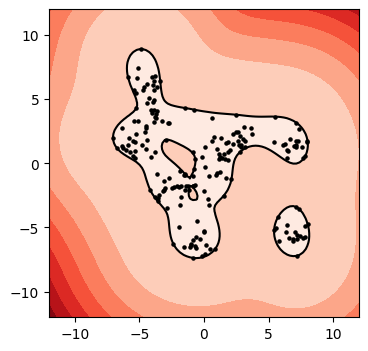

In [14]:
kernel = lambda x,y: sklearn.metrics.pairwise.rbf_kernel(x,y,gamma=0.1)
utils.plot(X,OCSVM(kernel,0.0001).fit(X).predict(utils.Xgrid),boundary=True)

We observe that all points are indeed either contained in the envelope or at the border of it. We can now test the OC-SVM with a larger parameter $\nu$, here, $\nu=0.1$ and run the code again:

     pcost       dcost       gap    pres   dres
 0:  5.9756e-02 -1.9792e+00  4e+02  2e+01  2e-15
 1:  6.6548e-02 -1.9549e+00  6e+00  2e-01  4e-15
 2:  7.2113e-02 -8.7545e-01  9e-01  3e-16  3e-15
 3:  7.0349e-02  1.9189e-02  5e-02  8e-16  1e-15
 4:  6.5181e-02  5.4344e-02  1e-02  1e-16  3e-16
 5:  6.3039e-02  5.9564e-02  3e-03  5e-16  3e-16
 6:  6.2249e-02  6.0824e-02  1e-03  1e-16  3e-16
 7:  6.1873e-02  6.1403e-02  5e-04  5e-17  2e-16
 8:  6.1728e-02  6.1573e-02  2e-04  1e-15  3e-16
 9:  6.1671e-02  6.1646e-02  3e-05  8e-16  3e-16
10:  6.1661e-02  6.1659e-02  2e-06  3e-17  3e-16
11:  6.1660e-02  6.1660e-02  4e-08  3e-16  3e-16
Optimal solution found.


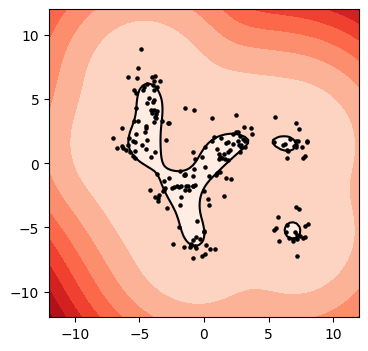

In [15]:
kernel = lambda x,y: sklearn.metrics.pairwise.rbf_kernel(x,y,gamma=0.1)
utils.plot(X,OCSVM(kernel,0.5).fit(X).predict(utils.Xgrid),boundary=True)

This time, not all data points are contained in the envelope, and some of them are therefore classified by the model as outlier.